# Assignment 3

### CS559: Machine Learning: Fundamentals and Applications
### Student Name: Komal Wavhal
### CWID: 20034443

# Question 1
Linear Discriminant Analysis (5 points) Please download the “processed.cleveland.data” from Heart-
disease data set in the UCI Machine Learning repository and implement a binary Fisher’s Linear Dis-
criminant Analysis to distinguish no-heart disease (0) from heart disease(1 – 4) and report your results.
Please read “heart-disease.names” for the explanation of features (13 features are used). Split data into
training (80%) and test (20%). Write down each step of your solution. You need to choose a decision
boundary and classify the test samples based on the decision boundary you learned from the training
data. Please report the data distributions (e.g., how many samples are no-heart disease and how many
are heart disease). Then report your results on the accuracy, recall, precision, and F1 (assuming heart
disease samples are positive samples) on the test data and plot the projected test samples using your
learned w.

In [332]:
!pip install ucimlrepo

    extract-msg (<=0.29.*)
                 ~~~~~~~^


# Step 1: Imports & dataset paths

In [334]:

import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Allowed (data processing): we use train_test_split purely to create a stratified split.
from sklearn.model_selection import train_test_split

# Paths to data files 
DATA_PATH = "processed.cleveland.data"
NAMES_PATH = "heart-disease.names"
assert os.path.exists(DATA_PATH), "processed.cleveland.data not found"
assert os.path.exists(NAMES_PATH), "heart-disease.names not found"



# Step 2:  heart-disease.names 

In [336]:
# Read .names
with open(NAMES_PATH, "r", encoding="utf-8", errors="ignore") as f:
    names_text = f.read()

# Print the first ~1200 chars
print(names_text[:1200], "...\n\n[truncated]")


Publication Request: 
   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
   This file describes the contents of the heart-disease directory.

   This directory contains 4 databases concerning heart disease diagnosis.
   All attributes are numeric-valued.  The data was collected from the
   four following locations:

     1. Cleveland Clinic Foundation (cleveland.data)
     2. Hungarian Institute of Cardiology, Budapest (hungarian.data)
     3. V.A. Medical Center, Long Beach, CA (long-beach-va.data)
     4. University Hospital, Zurich, Switzerland (switzerland.data)

   Each database has the same instance format.  While the databases have 76
   raw attributes, only 14 of them are actually used.  Thus I've taken the
   liberty of making 2 copies of each database: one with all the attributes
   and 1 with the 14 attributes actually used in past experiments.

   The authors of the databases have requested:

      ...that any publications resulting from the use of th

# Step 3: Load data, clean missing values, make binary label

In [338]:

# Load, clean, and binarize labels
# The file has 14 columns: 13 features + 1 target
cols = [f"f{i+1}" for i in range(13)] + ["target"]

# Read CSV, mark '?' as NA, drop NA rows, cast to float
df = pd.read_csv(DATA_PATH, header=None, names=cols)
df = df.replace("?", np.nan).dropna().astype(float)

# Binary label: 0 if target==0, else 1 (i.e., targets 1..4 -> 1)
df["y"] = (df["target"] > 0).astype(int)

# Separate features/labels
X = df[cols[:-1]].values   # 13 features as a NumPy array
y = df["y"].values.astype(int)

# Report class distribution after cleaning
n_total = len(y)
n_pos = int(y.sum())          # heart disease
n_neg = int((1 - y).sum())    # no heart disease
print(f"Total samples: {n_total}")
print(f"No heart disease (0): {n_neg}")
print(f"Heart disease (1):    {n_pos}")





Total samples: 297
No heart disease (0): 160
Heart disease (1):    137


In [340]:
# Step 3: Load data, clean missing values, make binary label
# ----------------------------------------------------------
# The file has 14 columns: 13 features + 1 target.
# We'll use ucimlrepo for clean download or fallback to local file if available.

from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np

# 1️⃣ Load the Heart Disease (Cleveland) dataset from UCI
heart_disease = fetch_ucirepo(id=45)  # ID 45 corresponds to the Heart Disease dataset

# 2️⃣ Extract data into pandas DataFrame
X = heart_disease.data.features
y_raw = heart_disease.data.targets

# 3️⃣ Convert the target to binary (0 = no heart disease, 1 = heart disease)
# Original target values: 0, 1, 2, 3, 4 → group 1–4 as 1
df = pd.concat([X, y_raw], axis=1)
df.columns = [f"f{i+1}" for i in range(13)] + ["target"]

# Drop missing rows (if any)
df = df.dropna()

# Binary label: 0 = no heart disease, 1 = has heart disease
df["y"] = (df["target"] > 0).astype(int)

# Extract features and labels
X = df.iloc[:, :-2].values  # 13 features
y = df["y"].values.astype(int)

# 4️⃣ Report class distribution
n_total = len(y)
n_pos = int(y.sum())          # heart disease
n_neg = int((1 - y).sum())    # no heart disease

print(f"✅ Dataset loaded successfully!")
print(f"Total samples: {n_total}")
print(f"No heart disease (0): {n_neg}")
print(f"Heart disease (1):    {n_pos}")


✅ Dataset loaded successfully!
Total samples: 297
No heart disease (0): 160
Heart disease (1):    137


# Split data into training (80%) and test (20%).


## Split 
- Perform a **stratified** train/test split:
  - Train = 80%, Test = 20%
  - `random_state = 42` (reproducibility)



In [343]:
# Step 4: Stratified train/test split (80/20)
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {len(y_tr)} (pos={int(y_tr.sum())}, neg={int((1-y_tr).sum())})")
print(f"Test  size: {len(y_te)} (pos={int(y_te.sum())}, neg={int((1-y_te).sum())})")


Train size: 237 (pos=109, neg=128)
Test  size: 60 (pos=28, neg=32)


# Implementing Fisher’s Linear Discriminant / LDA for a binary problem: LDA training


## 1) Load & Clean (Cell 3)
- Read `processed.cleveland.data` (Cleveland subset: 13 features + 1 target).
- Treat `"?"` as missing and drop rows with any missing values.
- Map target to binary:
  - `y = 0` if `target == 0`
  - `y = 1` if `target ∈ {1,2,3,4}` (heart disease = positive)


Classes:

0 = no heart disease

1 = heart disease (targets {1,2,3,4} collapsed to 1)

Model assumptions (standard LDA):

Each class is Gaussian with its own mean, shared covariance Σ
Priors 𝜋0,𝜋1 reflect class frequencies
The optimal discriminant is linear: 𝑔(𝑥) = 𝑤⊤𝑥 + 𝑏 
Parameters you estimate from the training data:
class means 𝜇0,𝜇1
pooled within-class covariance 𝑆𝑤
direction $$
w = S_w^{-1} (\mu_1 - \mu_0)
$$

$$
b = -\frac{1}{2}\left(\mu_1^{\top} S_w^{-1} \mu_1 - \mu_0^{\top} S_w^{-1} \mu_0\right)
+ \log\frac{\pi_1}{\pi_0}
$$

Decision rule: predict heart disease (1) if  g(x)>0; otherwise 0.


The Fisher's Linear Discriminant classifier is defined as:

$$
g(x) = w^{\top} x + b
$$

where

$$
w = S_w^{-1} (\mu_1 - \mu_0)
$$

and the decision rule is:

$$
\hat{y} =
\begin{cases}
1, & \text{if } g(x) > 0 \\
0, & \text{otherwise}
\end{cases}
$$



In [347]:
def fisher_lda_train(X, y, eps=1e-6):
    """
    Compute LDA parameters from training data.

    Returns:
      dict with:
        w: direction vector (d,)
        b: intercept scalar
        mu0, mu1: class means
        Sw: pooled within-class covariance (regularized)
        pi0, pi1: class priors
    """
    # Split by class (Cleveland labels already mapped to 0/1 in earlier cells)
    X0 = X[y == 0]                     # class 0 = no heart disease
    X1 = X[y == 1]                     # class 1 = heart disease

    # Compute sample means (shape: (d,))
    mu0 = X0.mean(axis=0)
    mu1 = X1.mean(axis=0)

    # Compute class covariances (shape: (d,d))
    # np.cov(..., rowvar=False) treats columns as variables (features)
    S0 = np.cov(X0, rowvar=False)
    S1 = np.cov(X1, rowvar=False)

    # Sample counts per class
    n0 = len(X0)
    n1 = len(X1)

    # Pooled within-class covariance (maximum-likelihood estimate under shared-Σ assumption)
    # Sw = ((n0-1)S0 + (n1-1)S1) / (n0 + n1 - 2)
    Sw = ((n0 - 1) * S0 + (n1 - 1) * S1) / (n0 + n1 - 2)

    # Regularize Sw slightly: numerical safety if Sw is nearly singular
    Sw = Sw + eps * np.eye(Sw.shape[0])

    # Fisher/LDA direction: w = Sw^{-1} (mu1 - mu0)
    # This is the direction that best separates the class means relative to within-class variance
    w = np.linalg.solve(Sw, (mu1 - mu0))

    # Class priors from training frequencies
    pi0 = n0 / (n0 + n1)
    pi1 = n1 / (n0 + n1)

    # Intercept (bias) term for the linear discriminant:
    # b = -0.5*(mu1^T inv(Sw) mu1 - mu0^T inv(Sw) mu0) + log(pi1/pi0)
    invSw = np.linalg.inv(Sw)
    term = 0.5 * (mu1 @ invSw @ mu1 - mu0 @ invSw @ mu0)
    b = -term + math.log(pi1 / pi0)

    return {"w": w, "b": b, "mu0": mu0, "mu1": mu1, "Sw": Sw, "pi0": pi0, "pi1": pi1}


In [348]:

# Train on the training split
lda_model = fisher_lda_train(X_tr, y_tr)
print("Learned |w| (L2 norm):", np.linalg.norm(lda_model["w"]))
print("Intercept b:", lda_model["b"])

Learned |w| (L2 norm): 2.348327468601236
Intercept b: -9.792131739307944


# Prediction & metrics

In [350]:
# Step 6: Make predictions and compute metrics

def lda_predict(model, X):
    """Return predicted labels and raw scores g(x) = w^T x + b."""
    scores = X @ model["w"] + model["b"]
    yhat = (scores > 0).astype(int)  # decision boundary at 0
    return yhat, scores

def compute_metrics(y_true, y_pred):
    """Return accuracy, precision, recall, F1 and confusion terms."""
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)

    tp = int(((y_true == 1) & (y_pred == 1)).sum())
    tn = int(((y_true == 0) & (y_pred == 0)).sum())
    fp = int(((y_true == 0) & (y_pred == 1)).sum())
    fn = int(((y_true == 1) & (y_pred == 0)).sum())

    accuracy  = (tp + tn) / len(y_true)
    precision = tp / max(1, (tp + fp))
    recall    = tp / max(1, (tp + fn))
    f1        = 0.0 if (precision + recall) == 0 else 2 * precision * recall / (precision + recall)

    return dict(tp=tp, fp=fp, tn=tn, fn=fn,
                accuracy=accuracy, precision=precision, recall=recall, f1=f1)

# Train and test predictions
yhat_tr, s_tr = lda_predict(lda_model, X_tr)
yhat_te, s_te = lda_predict(lda_model, X_te)

m_tr = compute_metrics(y_tr, yhat_tr)
m_te = compute_metrics(y_te, yhat_te)

print("TRAIN metrics:", m_tr)
print("TEST  metrics:", m_te)


TRAIN metrics: {'tp': 88, 'fp': 14, 'tn': 114, 'fn': 21, 'accuracy': 0.8523206751054853, 'precision': 0.8627450980392157, 'recall': 0.8073394495412844, 'f1': 0.8341232227488152}
TEST  metrics: {'tp': 22, 'fp': 3, 'tn': 29, 'fn': 6, 'accuracy': 0.85, 'precision': 0.88, 'recall': 0.7857142857142857, 'f1': 0.830188679245283}


In [351]:
def print_block(title, m):
    print(title)
    print(f"  Accuracy : {m['accuracy']:.4f}")
    print(f"  Precision: {m['precision']:.4f}")
    print(f"  Recall   : {m['recall']:.4f}")
    print(f"  F1-score : {m['f1']:.4f}")
    print(f"  Confusion: TP={m['tp']}, FP={m['fp']}, TN={m['tn']}, FN={m['fn']}")
    print()

print_block("=== TRAIN metrics (positive = heart disease) ===", m_tr)
print_block("=== TEST  metrics (positive = heart disease) ===",  m_te)

=== TRAIN metrics (positive = heart disease) ===
  Accuracy : 0.8523
  Precision: 0.8627
  Recall   : 0.8073
  F1-score : 0.8341
  Confusion: TP=88, FP=14, TN=114, FN=21

=== TEST  metrics (positive = heart disease) ===
  Accuracy : 0.8500
  Precision: 0.8800
  Recall   : 0.7857
  F1-score : 0.8302
  Confusion: TP=22, FP=3, TN=29, FN=6




## Visualize (projection plot)
- Plot test samples’ **1D projections** \(g(x)\) with slight vertical jitter.
- Draw a vertical dashed line at **0** to indicate the **decision boundary**.


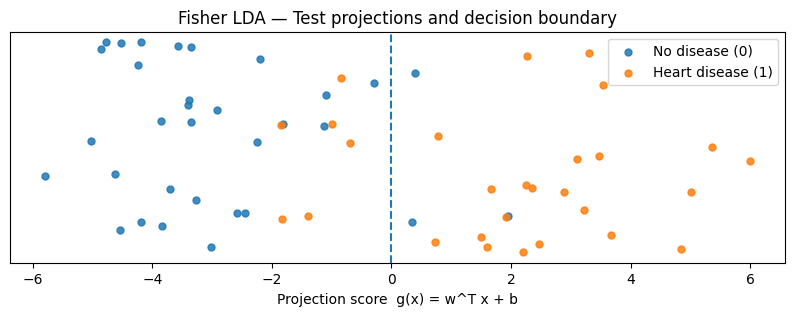

In [353]:
# Step 7: Plot test projections along g(x) = w^T x + b

plt.figure(figsize=(10, 3))

# Small vertical jitter to see overlapping points
jitter = (np.random.rand(len(s_te)) - 0.5) * 0.02

plt.scatter(s_te[y_te==0], jitter[y_te==0], s=25, alpha=0.85, label="No disease (0)")
plt.scatter(s_te[y_te==1], jitter[y_te==1], s=25, alpha=0.85, label="Heart disease (1)")

# Decision boundary at g(x) = 0
plt.axvline(0.0, linestyle="--")

plt.yticks([])
plt.xlabel("Projection score  g(x) = w^T x + b")
plt.title("Fisher LDA — Test projections and decision boundary")
plt.legend(loc="best")
plt.show()


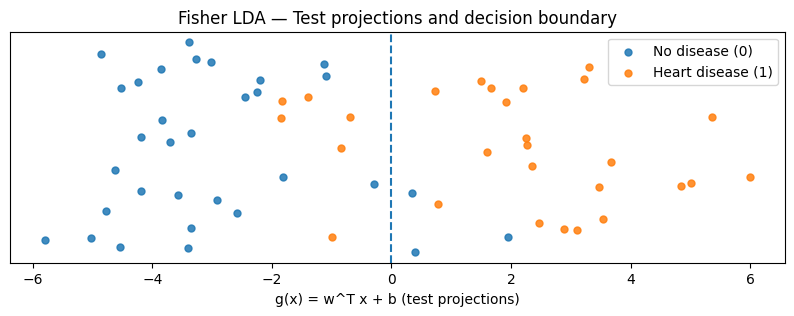

In [354]:
# Visualization: 1D projection on test set ----------
plt.figure(figsize=(10, 3))
jit = (np.random.rand(len(s_te)) - 0.5) * 0.02
plt.scatter(s_te[y_te==0], jit[y_te==0], s=25, alpha=0.85, label="No disease (0)")
plt.scatter(s_te[y_te==1], jit[y_te==1], s=25, alpha=0.85, label="Heart disease (1)")
plt.axvline(0.0, linestyle="--")                 # decision boundary at 0
plt.yticks([])
plt.xlabel("g(x) = w^T x + b (test projections)")
plt.title("Fisher LDA — Test projections and decision boundary")
plt.legend(loc="best")
plt.show()

In [355]:
!pip install jupyterlab-mathjax3

    extract-msg (<=0.29.*)
                 ~~~~~~~^


# Question 2
Generative methods vs Discriminative methods (10 points) Please download the breast cancer
data set from UCI Machine Learning repository. You can either use “breast-cancer-wisconsin.data” or
“wdbc.data”. Please check their corresponding “.names” files for the explanation of features and labels.
1. (2 pts) Show that the derivative of the error function in Logistic Regression with respect to w is: (Gradient of the Error Function)

$$
\nabla_{w} E(w) = \sum_{n=1}^{N} (f(x_n) - y_n) \, x_n
$$

2. (4 pts) Implement a logistic regression classifier with maximum likelihood (ML) estimator using
Stochastic gradient descent and Mini-Batch gradient descent algorithms. Divide the data into
training and test. Choose a proper learning rate. Use cross-validation on the training data to
choose the best model and report the recall, precision, and accuracy on malignant class prediction
(class label malignant is positive) on the test data using the best model. Write down each step of
your solution.

3. (4 pts) Implement a probabilistic generative model (the one in our lecture) for this problem. Use
cross-validation on the training data and report the recall, precision, and accuracy on malignant
class prediction (class label malignant is positive) on the test data using the best model. Write
down each step of your solution.

## 1) Theory — Derivative of Logistic Regression Error

Binary labels $y_n \in \{0,1\}$. Logistic model:

$$
f(x_n) = \sigma(w^\top x_n) = \frac{1}{1 + e^{-w^\top x_n}}.
$$

Negative log-likelihood (NLL) error:

$$
E(w) = -\sum_{n=1}^{N} \Big[ y_n \log f(x_n) + (1 - y_n)\log\big(1 - f(x_n)\big) \Big].
$$

Key facts: $\frac{d}{dz}\sigma(z) = \sigma(z)(1-\sigma(z))$, and $\frac{\partial}{\partial w}(w^\top x_n) = x_n$.

Differentiate a single term:

$$
\frac{\partial}{\partial w}\left[-y_n\log f(x_n) - (1-y_n)\log(1-f(x_n))\right]
= -\left[ \frac{y_n}{f(x_n)} - \frac{1-y_n}{1-f(x_n)} \right] \frac{\partial f(x_n)}{\partial w}.
$$

Also,

$$
\frac{\partial f(x_n)}{\partial w} = f(x_n)(1-f(x_n))\,x_n.
$$

Thus,

$$
- \big[ y_n(1-f(x_n)) - (1-y_n)f(x_n) \big] x_n = (f(x_n) - y_n)\,x_n.
$$

Summing over all samples:

$$
\boxed{ \nabla_w E(w) = \sum_{n=1}^{N} (f(x_n) - y_n)\,x_n }.
$$


### Setup & Imports

In [359]:
# 2) Practical Part — Setup
# numpy/pandas for math/data, sklearn utilities for splitting/cross-validation only.
import os, math
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold  # allowed for CV/splitting

# Reproducibility
RNG_SEED = 42
np.random.seed(RNG_SEED)
print('Environment ready. RNG_SEED =', RNG_SEED)


Environment ready. RNG_SEED = 42


In [360]:
### Load Data

In [361]:
# Load WDBC data and inspect
# Update 'data_path' if your files are elsewhere.
data_path = 'wdbc.data'
names_path = 'wdbc.names'

assert os.path.exists(data_path), 'wdbc.data not found in current directory'
assert os.path.exists(names_path), 'wdbc.names not found in current directory'

# UCI WDBC format: id, diagnosis(M/B), 30 float features
df = pd.read_csv(data_path, header=None)
print('Raw shape:', df.shape)
df.head()


Raw shape: (569, 32)


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Prepare X, y

In [363]:
# Prepare features and labels
# 1) Name columns: id, diagnosis, 30 features
# 2) Encode labels: malignant 'M' -> 1 (positive), benign 'B' -> 0
# 3) Extract X (features) and y (labels)
num_features = 30
df.columns = ['id', 'diagnosis'] + [f'f{i+1}' for i in range(num_features)]
df['y'] = (df['diagnosis'] == 'M').astype(int)  # malignant=1

feature_cols = [f'f{i+1}' for i in range(num_features)]
X = df[feature_cols].values.astype(float)
y = df['y'].values.astype(int)

print('Features shape:', X.shape, '| Labels shape:', y.shape)
print('Label counts (0=benign,1=malignant):', np.bincount(y))


Features shape: (569, 30) | Labels shape: (569,)
Label counts (0=benign,1=malignant): [357 212]


### Train/Test

In [365]:
# Train/test split (stratified) and standardization using training statistics only
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RNG_SEED
)

def standardize_fit_transform(X_train):
    """Compute mean/std on training set and return them."""
    mu = X_train.mean(axis=0)
    sigma = X_train.std(axis=0, ddof=0)
    sigma[sigma == 0] = 1.0  # guard against zero variance
    return mu, sigma

def standardize_apply(X, mu, sigma):
    """Apply standardization with provided training mu/sigma."""
    return (X - mu) / sigma

mu, sigma = standardize_fit_transform(X_train)
X_train_std = standardize_apply(X_train, mu, sigma)
X_test_std  = standardize_apply(X_test,  mu, sigma)

X_train_std.shape, X_test_std.shape


((455, 30), (114, 30))

### Metrics

In [367]:
# Metrics for malignant (positive=1)
def confusion_counts(y_true, y_pred, positive=1):
    """Return TP, FP, FN, TN for the given positive class label."""
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)
    TP = np.sum((y_true == positive) & (y_pred == positive))
    FP = np.sum((y_true != positive) & (y_pred == positive))
    FN = np.sum((y_true == positive) & (y_pred != positive))
    TN = np.sum((y_true != positive) & (y_pred != positive))
    return TP, FP, FN, TN

def precision_recall_accuracy(y_true, y_pred, positive=1):
    """Compute precision, recall, accuracy for the positive class."""
    TP, FP, FN, TN = confusion_counts(y_true, y_pred, positive)
    precision = TP / (TP + FP) if (TP + FP) else 0.0
    recall    = TP / (TP + FN) if (TP + FN) else 0.0
    accuracy  = (TP + TN) / (TP + FP + FN + TN)
    return precision, recall, accuracy

def f1_score(y_true, y_pred, positive=1):
    """Compute F1 score for the positive class."""
    p, r, _ = precision_recall_accuracy(y_true, y_pred, positive)
    return (2*p*r)/(p+r) if (p+r) else 0.0

print('Metric utilities ready.')


Metric utilities ready.


### Logistic Regression with SGD & Mini-Batch 

In [369]:
# Logistic Regression (from scratch) — supports SGD (batch_size=1) and Mini-batch (batch_size>1)

def sigmoid(z):
    """Numerically stable sigmoid."""
    z = np.asarray(z)
    out = np.empty_like(z, dtype=float)
    pos = z >= 0
    neg = ~pos
    out[pos] = 1.0 / (1.0 + np.exp(-z[pos]))
    ez = np.exp(z[neg])
    out[neg] = ez / (1.0 + ez)
    return out

def predict_proba(X, w, b):
    """Return P(y=1|x) = sigmoid(w^T x + b)."""
    return sigmoid(X @ w + b)

def predict_label(X, w, b, threshold=0.5):
    """Return hard labels with threshold (default 0.5)."""
    return (predict_proba(X, w, b) >= threshold).astype(int)

def logistic_batch_grad(Xb, yb, w, b):
    """Gradient of NLL for a batch:
       grad_w = Xb^T (p - y), grad_b = sum(p - y)
    """
    pb = predict_proba(Xb, w, b)
    diff = pb - yb
    grad_w = Xb.T @ diff
    grad_b = np.sum(diff)
    return grad_w, grad_b

def train_logistic(X, y, lr=0.05, epochs=100, batch_size=1, l2=0.0, shuffle=True, seed=42, verbose=False):
    """
    Train logistic regression via SGD/Mini-batch GD.
    - X: (N, d) standardized
    - y: (N,) in {0,1}
    - lr: learning rate
    - epochs: passes over data
    - batch_size: 1 => pure SGD; >1 => mini-batch GD
    - l2: L2 regularization coefficient (0.0 => none)
    """
    N, d = X.shape
    rng = np.random.default_rng(seed)
    w = np.zeros(d)   # initialize weights to 0
    b = 0.0           # initialize bias to 0

    def batches():
        """Yield index batches for one epoch."""
        idx = np.arange(N)
        if shuffle:
            rng.shuffle(idx)
        for s in range(0, N, batch_size):
            yield idx[s:s+batch_size]

    def loss_full():
        """Average negative log-likelihood + L2 penalty."""
        p = predict_proba(X, w, b)
        eps = 1e-12
        nll = -np.mean(y*np.log(p+eps) + (1-y)*np.log(1-p+eps))
        return nll + 0.5*l2*np.dot(w, w)

    history = []
    for ep in range(1, epochs+1):
        for bi in batches():
            Xb, yb = X[bi], y[bi]
            gw, gb = logistic_batch_grad(Xb, yb, w, b)
            if l2:
                gw = gw + l2*w
            # scale updates by batch size (average gradient step)
            w -= lr * gw / len(bi)
            b -= lr * gb / len(bi)
        L = loss_full()
        history.append((ep, L))
        if verbose and ep % max(1, epochs//5) == 0:
            print(f'Epoch {ep:4d}/{epochs}: loss={L:.4f}')
    return w, b, history

print('Logistic regression implementation ready.')


Logistic regression implementation ready.


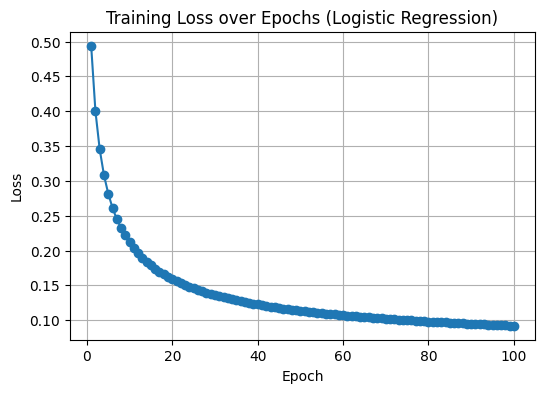

In [370]:
import matplotlib.pyplot as plt

epochs = [e for e, _ in hist_lr]
losses = [L for _, L in hist_lr]

plt.figure(figsize=(6,4))
plt.plot(epochs, losses, marker='o')
plt.title('Training Loss over Epochs (Logistic Regression)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


### Cross-Validation for Logistic Regression 

In [372]:
# Cross-validation for Logistic Regression — select hyperparams by mean validation F1 on malignant class.
from pprint import pprint

def crossval_logreg(X, y, param_grid, n_splits=5, seed=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    rows = []
    for lr in param_grid['lr']:
        for epochs in param_grid['epochs']:
            for batch_size in param_grid['batch_size']:
                for l2 in param_grid.get('l2', [0.0]):
                    scores = []
                    for tr, va in skf.split(X, y):
                        Xtr, Xva = X[tr], X[va]
                        ytr, yva = y[tr], y[va]
                        # Train on training fold
                        w, b, _ = train_logistic(
                            Xtr, ytr, lr=lr, epochs=epochs, batch_size=batch_size, l2=l2,
                            seed=seed, verbose=False
                        )
                        # Validate on validation fold
                        yhat = predict_label(Xva, w, b)
                        scores.append(f1_score(yva, yhat, positive=1))
                    rows.append({'lr': lr, 'epochs': epochs, 'batch_size': batch_size, 'l2': l2,
                                 'mean_val_f1': float(np.mean(scores))})
    df = pd.DataFrame(rows).sort_values('mean_val_f1', ascending=False)
    best = df.iloc[0].to_dict()
    return df, best

# A compact but meaningful grid (kept small for runtime)
param_grid = {
    'lr': [0.01, 0.05, 0.1],
    'epochs': [100, 200],
    'batch_size': [1, 16, 32],  # 1 => SGD; 16/32 => Mini-batch
    'l2': [0.0, 0.001]
}

cv_results_logreg, best_logreg = crossval_logreg(X_train_std, y_train, param_grid, n_splits=5, seed=RNG_SEED)
print('Top CV rows:')
print(cv_results_logreg.head())
print('\nBest Logistic hyperparams:')
pprint(best_logreg)


Top CV rows:
      lr  epochs  batch_size     l2  mean_val_f1
4   0.01     100          32  0.000     0.966967
5   0.01     100          32  0.001     0.966967
0   0.01     100           1  0.000     0.963977
14  0.05     100          16  0.000     0.963977
34  0.10     200          32  0.000     0.963977

Best Logistic hyperparams:
{'batch_size': 32.0,
 'epochs': 100.0,
 'l2': 0.0,
 'lr': 0.01,
 'mean_val_f1': 0.9669672918472398}


### Train Final Logistic & Evaluate on Test

In [374]:
# Retrain Logistic with best hyperparams on full training; evaluate on test (malignant=positive)
best_lr = float(best_logreg['lr'])
best_epochs = int(best_logreg['epochs'])
best_batch = int(best_logreg['batch_size'])
best_l2 = float(best_logreg['l2'])

w_lr, b_lr, hist_lr = train_logistic(
    X_train_std, y_train, lr=best_lr, epochs=best_epochs, batch_size=best_batch,
    l2=best_l2, seed=RNG_SEED, verbose=True
)

y_test_pred_lr = predict_label(X_test_std, w_lr, b_lr)

prec_lr, rec_lr, acc_lr = precision_recall_accuracy(y_test, y_test_pred_lr, positive=1)
f1_lr = f1_score(y_test, y_test_pred_lr, positive=1)
TP, FP, FN, TN = confusion_counts(y_test, y_test_pred_lr, positive=1)

print('=== Logistic Regression — Test (Malignant=Positive) ===')
print(f'Precision: {prec_lr:.4f}\nRecall:    {rec_lr:.4f}\nAccuracy:  {acc_lr:.4f}\nF1:        {f1_lr:.4f}')
print('Confusion [TP, FP, FN, TN]:', [TP, FP, FN, TN])


Epoch   20/100: loss=0.1589
Epoch   40/100: loss=0.1226
Epoch   60/100: loss=0.1071
Epoch   80/100: loss=0.0981
Epoch  100/100: loss=0.0921
=== Logistic Regression — Test (Malignant=Positive) ===
Precision: 1.0000
Recall:    0.9524
Accuracy:  0.9825
F1:        0.9756
Confusion [TP, FP, FN, TN]: [40, 0, 2, 72]


### Generative Model (GDA, shared covariance) from scratch 

In [376]:
# Generative Model: Gaussian Discriminant Analysis (shared covariance, LDA-style)
# Assumptions: x|y=0 ~ N(mu0, Sigma), x|y=1 ~ N(mu1, Sigma); P(y=1) = pi
# Linear discriminant: g(x) = w^T x + b
# where w = Sigma^{-1} (mu1 - mu0),
#       b = -0.5 mu1^T Sigma^{-1} mu1 + 0.5 mu0^T Sigma^{-1} mu0 + log(pi/(1-pi)).

def fit_gda_shared_cov(X, y, eps=1e-6):
    """Fit GDA with shared covariance; eps adds diagonal regularization to Sigma."""
    X = np.asarray(X, float)
    y = np.asarray(y, int)
    N, d = X.shape
    pi = np.mean(y == 1)
    mu0 = X[y==0].mean(axis=0)
    mu1 = X[y==1].mean(axis=0)
    X0 = X[y==0] - mu0
    X1 = X[y==1] - mu1
    Sigma = (X0.T @ X0 + X1.T @ X1) / N  # pooled covariance MLE
    Sigma += eps * np.eye(d)
    Sigma_inv = np.linalg.inv(Sigma)
    w = Sigma_inv @ (mu1 - mu0)
    b = -0.5 * (mu1 @ Sigma_inv @ mu1) + 0.5 * (mu0 @ Sigma_inv @ mu0) + math.log(pi/(1-pi))
    return {'w': w, 'b': b, 'mu0': mu0, 'mu1': mu1, 'Sigma': Sigma, 'pi': pi, 'eps': eps}

def predict_gda(X, model):
    """Predict labels using g(x) = w^T x + b >= 0."""
    w, b = model['w'], model['b']
    return (X @ w + b >= 0).astype(int)

print('GDA implementation ready.')


GDA implementation ready.


### Cross-Validation for GDA

In [378]:
# Cross-validate epsilon regularization for Sigma inversion stability (select by mean validation F1)
def crossval_gda(X, y, eps_list, n_splits=5, seed=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    rows = []
    for eps in eps_list:
        scores = []
        for tr, va in skf.split(X, y):
            Xtr, Xva = X[tr], X[va]
            ytr, yva = y[tr], y[va]
            model = fit_gda_shared_cov(Xtr, ytr, eps=eps)
            yhat = predict_gda(Xva, model)
            scores.append(f1_score(yva, yhat, positive=1))
        rows.append({'eps': eps, 'mean_val_f1': float(np.mean(scores))})
    df = pd.DataFrame(rows).sort_values('mean_val_f1', ascending=False)
    best = df.iloc[0].to_dict()
    return df, best

eps_list = [1e-8, 1e-6, 1e-4, 1e-2]
cv_results_gda, best_gda = crossval_gda(X_train_std, y_train, eps_list, n_splits=5, seed=RNG_SEED)
print('GDA CV results:')
print(cv_results_gda)
print('\nBest GDA hyperparam:', best_gda)


GDA CV results:
            eps  mean_val_f1
2  1.000000e-04     0.937266
3  1.000000e-02     0.936976
0  1.000000e-08     0.936860
1  1.000000e-06     0.936860

Best GDA hyperparam: {'eps': 0.0001, 'mean_val_f1': 0.9372663179114792}


In [379]:
### Train Final GDA & Evaluate on Test

In [380]:
# Retrain GDA with best eps on full training; evaluate on test (malignant=positive)
best_eps = float(best_gda['eps'])
gda_model = fit_gda_shared_cov(X_train_std, y_train, eps=best_eps)
y_test_pred_gda = predict_gda(X_test_std, gda_model)

prec_gda, rec_gda, acc_gda = precision_recall_accuracy(y_test, y_test_pred_gda, positive=1)
f1_gda = f1_score(y_test, y_test_pred_gda, positive=1)
TPg, FPg, FNg, TNg = confusion_counts(y_test, y_test_pred_gda, positive=1)

print('=== GDA — Test (Malignant=Positive) ===')
print(f'Precision: {prec_gda:.4f}\nRecall:    {rec_gda:.4f}\nAccuracy:  {acc_gda:.4f}\nF1:        {f1_gda:.4f}')
print('Confusion [TP, FP, FN, TN]:', [TPg, FPg, FNg, TNg])


=== GDA — Test (Malignant=Positive) ===
Precision: 1.0000
Recall:    0.9048
Accuracy:  0.9649
F1:        0.9500
Confusion [TP, FP, FN, TN]: [38, 0, 4, 72]


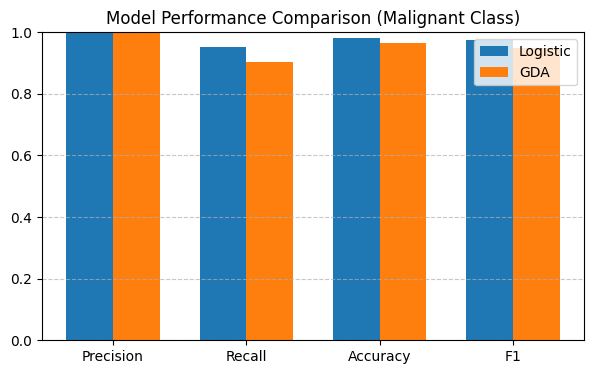

In [381]:
metrics = ['Precision', 'Recall', 'Accuracy', 'F1']
logreg_vals = [prec_lr, rec_lr, acc_lr, f1_lr]
gda_vals = [prec_gda, rec_gda, acc_gda, f1_gda]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(7,4))
plt.bar(x - width/2, logreg_vals, width, label='Logistic')
plt.bar(x + width/2, gda_vals, width, label='GDA')
plt.xticks(x, metrics)
plt.title('Model Performance Comparison (Malignant Class)')
plt.ylim(0,1)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


#### Comparison Table

In [383]:
# Side-by-side comparison on test set
summary = pd.DataFrame([
    {'Model': 'Logistic (best CV)', 'Precision': prec_lr, 'Recall': rec_lr, 'Accuracy': acc_lr, 'F1': f1_lr},
    {'Model': 'GDA (best CV)',      'Precision': prec_gda, 'Recall': rec_gda, 'Accuracy': acc_gda, 'F1': f1_gda},
]).set_index('Model')
summary


,Precision,Recall,Accuracy,F1
Model,,,,
Logistic (best CV),1.0,0.952381,0.982456,0.97561
GDA (best CV),1.0,0.904762,0.964912,0.95000


## Question 3 Linear classification (5 points) 

### Please prove that 


### 1) The multinomial naive Bayes classifier in log-space essentially translates to a linear classifier. 

#### 1) Model Setup — Multinomial Naïve Bayes

Let  
$\displaystyle x = (x_1, x_2, \dots, x_d)$  
be the **feature vector** of word counts (for text) or other nonnegative integers,  
and let $\displaystyle y \in \{1, \dots, K\}$ denote the **class label**.


### Model Assumptions

The **Multinomial Naïve Bayes** model assumes:

#### Prior:
$$
P(y = c) = \pi_c
$$

#### Likelihood (Naïve Bayes independence assumption):
$$
P(x \mid y = c)
= 
\frac{\left(\sum_{j} x_j\right)!}{\prod_{j} x_j!}
\prod_{j=1}^{d} \theta_{cj}^{\,x_j},
$$

where each class \( c \) has its own multinomial parameters  
\(\theta_{cj} \ge 0\) satisfying

$$
\sum_{j=1}^{d} \theta_{cj} = 1.
$$


#### 2) Posterior and Decision Rule — Multinomial Naïve Bayes

Using **Bayes’ theorem**:

$$
P(y = c \mid x)
\propto
P(y = c)\,P(x \mid y = c)
\propto
\pi_c
\prod_{j=1}^{d} \theta_{cj}^{\,x_j}.
$$

The proportionality holds because the **multinomial coefficient**
$\displaystyle \frac{(\sum_j x_j)!}{\prod_j x_j!}$
does not depend on the class \(c\).


### Log-space Form

Taking logarithms (since the denominator is constant across all \(c\)):

$$
\log P(y = c \mid x)
= \log \pi_c
+ \sum_{j=1}^{d} x_j \log \theta_{cj}
+ \text{constant (in } x\text{)}.
$$

The additive term “constant (in $x$)” is the same for all classes,  
so it cancels when comparing class scores.


### Decision Rule

The classifier predicts the class with the highest log-posterior:

$$
\hat{y}(x)
= \arg\max_c \log P(y = c \mid x)
= \arg\max_c \Big( \log \pi_c + \sum_{j=1}^{d} x_j \log \theta_{cj} \Big).
$$

Thus, the **Multinomial Naïve Bayes** decision rule is based on a  
**linear combination** of features \(x_j\) weighted by \(\log \theta_{cj}\).


#### 3) Linear Form — Multinomial Naïve Bayes

Define

$$
b_c = \log \pi_c,
\qquad
w_{cj} = \log \theta_{cj}.
$$

Then the log-posterior becomes:

$$
\log P(y = c \mid x)
= b_c + \sum_{j=1}^{d} w_{cj} x_j
= b_c + w_c^\top x.
$$

### Decision Rule

The predicted class is chosen by the **maximum linear score**:

$$
\hat{y}(x)
= \arg\max_c \big( b_c + w_c^\top x \big),
$$

which defines a **linear discriminant function**.


### Interpretation

Thus, the **Multinomial Naïve Bayes classifier** is **linear in the input vector** \(x\) when expressed in **log-space**.  
Each class \(c\) has:
- Weight vector $$ (w_c = [\log \theta_{c1}, \dots, \log \theta_{cd}]^\top)$$
- Bias term $$ (b_c = \log \pi_c)$$

The decision boundaries between classes are **linear hyperplanes** in the feature space.


## 2) Theory — Multinomial Naive Bayes as a Linear Classifier

### Setup

Let  
$\displaystyle x = (x_1, \dots, x_d)$  
be a bag-of-words **count vector** (nonnegative integers), and  
$\displaystyle y \in \{1, \dots, K\}$  
be the class label.

The **multinomial Naive Bayes model** assumes:

#### Prior:
$$
P(y = c) = \pi_c
$$

#### Likelihood (Naive Bayes independence):
$$
P(x \mid y = c)
= \frac{\left( \sum_{j} x_j \right)!}{\prod_{j} x_j!} 
\prod_{j=1}^{d} \theta_{cj}^{\,x_j},
\quad \text{with } \theta_{cj} \ge 0, \ \sum_j \theta_{cj} = 1.
$$

### Posterior (up to a constant in \(x\))

Using Bayes’ rule:

$$
P(y = c \mid x)
\propto P(y = c)\,P(x \mid y = c)
\propto \pi_c \prod_{j=1}^{d} \theta_{cj}^{\,x_j},
$$

since the multinomial coefficient  
$\displaystyle \frac{(\sum_j x_j)!}{\prod_j x_j!}$  
does **not** depend on \(c\).

### Log-space scores

Define the **class score**:

$$
s_c(x)
= \log P(y = c \mid x)
= \log \pi_c + \sum_{j=1}^{d} x_j \log \theta_{cj} + (\text{const in } x).
$$

The additive term “const in \(x\)” is the same for all classes \(c\) and cancels out in  
$\arg\max_c$ comparisons.

### Linear form

Let
$$
w_{cj} = \log \theta_{cj}, 
\quad b_c = \log \pi_c.
$$

Then:
$$
s_c(x) = b_c + \sum_{j=1}^{d} w_{cj} x_j = b_c + w_c^\top x.
$$

### Prediction rule

The predicted class is:
$$
\hat{y}(x) = \arg\max_c s_c(x) = \arg\max_c (b_c + w_c^\top x).
$$

Thus, **multinomial Naive Bayes is a linear classifier in \(x\)**.

### Note 

Laplace/additive smoothing simply adjusts the parameter estimates
$$ (\theta_{cj})$$, and hence modifies $$ (w_{cj} = \log \theta_{cj}) $$,
but **preserves the linear decision boundary**.


## 2) Logistic regression is a linear classifier .

### Theory — Logistic Regression as a Linear Classifier

### Model Definition

Consider **binary logistic regression** with  
$y \in \{0, 1\}$ and feature vector $x \in \mathbb{R}^d$.

The model is:

$$
P(y = 1 \mid x)
= \sigma(w^\top x + b)
= \frac{1}{1 + \exp\!\left[-(w^\top x + b)\right]}.
$$


### Decision Rule at 0.5 Threshold

We classify $\hat{y} = 1$ if $P(y = 1 \mid x) \ge \tfrac{1}{2}$.

Since $\sigma(\cdot)$ is **monotonically increasing**,

$$
P(y = 1 \mid x) \ge \tfrac{1}{2}
\quad \Longleftrightarrow \quad
w^\top x + b \ge 0.
$$

Thus, the **decision boundary** is:

$$
\{\, x : w^\top x + b = 0 \,\},
$$

a **hyperplane** in the feature space.  
The classifier assigns classes based on the sign of the linear score $w^\top x + b$.

### Log-Odds Interpretation

Taking the log-odds (logit) form:

$$
\log \frac{P(y = 1 \mid x)}{P(y = 0 \mid x)}
= w^\top x + b,
$$

which is **linear in $x$**.

Hence, **logistic regression is a linear classifier** —  
it separates classes using a linear decision surface in the input space.


### Extension to Multiclass (Softmax) Logistic Regression

For multiple classes $c \in \{1, \dots, K\}$,  
define linear class scores:

$$
s_c(x) = w_c^\top x + b_c.
$$

The model uses the **softmax function**:

$$
P(y = c \mid x)
= \frac{e^{s_c(x)}}{\sum_{c'} e^{s_{c'}(x)}}.
$$

Prediction is made via:

$$
\hat{y}(x) = \arg\max_c s_c(x),
$$

again showing that **softmax logistic regression** uses **linear decision boundaries**.



## 1) Model Setup — Logistic Regression

For **binary classification** with  
$y \in \{0, 1\}$ and feature vector $x \in \mathbb{R}^d$,

the model is:

$$
P(y = 1 \mid x)
= \sigma(w^\top x + b)
= \frac{1}{1 + e^{-(w^\top x + b)}}.
$$

Here, $\sigma(\cdot)$ denotes the **sigmoid (logistic)** function.


### ⚖️ Decision Rule

We predict $\hat{y} = 1$ if

$$
P(y = 1 \mid x) \ge \frac{1}{2}.
$$

Since the sigmoid function $\sigma(\cdot)$ is **monotonically increasing**,

$$
P(y = 1 \mid x) \ge \frac{1}{2}
\;\Longleftrightarrow\;
w^\top x + b \ge 0.
$$

Thus, the **decision boundary** is the hyperplane:

$$
\{\, x : w^\top x + b = 0 \,\}.
$$

The classifier assigns classes based on the **sign** of the linear score \( w^\top x + b \).


###  Log-Odds (Logit) Form

Taking **log-odds**:

$$
\log \frac{P(y = 1 \mid x)}{P(y = 0 \mid x)}
= w^\top x + b,
$$

which is **linear in $x$**.

Hence, **logistic regression is a linear classifier** —  
its decision rule depends on the **sign of a linear function** of \(x\).


###  Multiclass (Softmax) Extension

For multiple classes \( c \in \{1, \dots, K\} \):

$$
s_c(x) = w_c^\top x + b_c,
$$

and the softmax probabilities are:

$$
P(y = c \mid x)
= \frac{e^{s_c(x)}}{\sum_{c'} e^{s_{c'}(x)}}.
$$

Prediction is made by:

$$
\hat{y}(x)
= \arg\max_c s_c(x),
$$

which is **still linear in \(x\)**.


 **Conclusion:**  
Both **binary** and **multiclass logistic regression** use **linear decision boundaries**,  
making them **linear classifiers** in the input space.



